In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
import seaborn as sns
stopwords_list = stopwords.words('english')
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stopwords_list = [stemmer.stem(word) for word in stopwords_list]
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('/Users/dhruvil/Downloads/100k-courseras-course-reviews-dataset/reviews.csv')
data = data.iloc[:50000,:]

In [3]:
data.head()
#we have reviews and corresponding ratings as labels

,Id,Review,Label
0,0,good and interesting,5
1,1,"This class is very helpful to me. Currently, I...",5
2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,Easy to follow and includes a lot basic and im...,5
4,4,Really nice teacher!I could got the point eazl...,4


## Let's clean and explore the data

In [4]:
def clean_review(review):
    '''
    --perform lower casing and punctuation removal 
    '''
    review = review.lower()
    review = review.translate(str.maketrans(string.punctuation,len(string.punctuation)*' '))
    review = ' '.join([stemmer.stem(word) for word in review.split()])
    return review
    
data['cleaned_reviews'] = data['Review'].apply(lambda x: clean_review(x))

In [5]:
data.head()

,Id,Review,Label,cleaned_reviews
0,0,good and interesting,5,good and interest
1,1,"This class is very helpful to me. Currently, I...",5,thi class is veri help to me current i m still...
2,2,like!Prof and TAs are helpful and the discussi...,5,like prof and ta are help and the discuss amon...
3,3,Easy to follow and includes a lot basic and im...,5,easi to follow and includ a lot basic and impo...
4,4,Really nice teacher!I could got the point eazl...,4,realli nice teacher i could got the point eazl...


<BarContainer object of 5 artists>

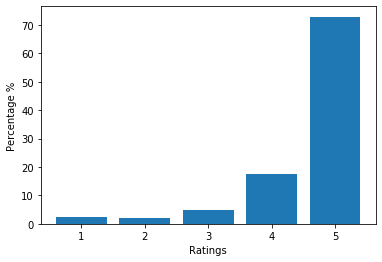

In [6]:
#always useful to know the distribution of target variable
label_counts = dict(Counter(data['Label']))
no_of_reviews = data.shape[0]
percentage_rating = [rating/no_of_reviews*100 for rating in label_counts.values()]

plt.xlabel('Ratings')
plt.ylabel('Percentage %')
plt.bar(label_counts.keys(), percentage_rating)


#Looks like Coursera is doing an amazing job! Around 90% of reviews have >=4 rating

## Sentence level EDA

In [7]:
#Let's explore sentence level feautures

In [8]:

data['num_words'] = data['cleaned_reviews'].apply(lambda x: len(x.split()))
data['num_stopwords'] = data['cleaned_reviews'].apply(lambda x: len([word for 
                                                            word in x.split() if word in stopwords_list]))
data['num_sentences'] = data['cleaned_reviews'].apply(lambda x: len(x.split('.')))


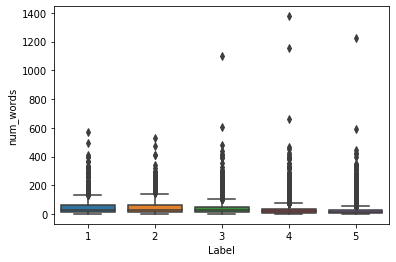

In [9]:
sns.boxplot(x = 'Label', y = 'num_words',data = data)
#We have too many outliers. Let's do something about them

In [10]:
#Let's exampine n-tiles
def ntiles(data, col_name):
    for i in range(100,0,-10):
        print("At {0}th percentile: {1}".format(i,np.percentile(data[col_name],i)))

ntiles(data,'num_words')
#We remove the top 10%. But before that, lets see which classes do they belong to

At 100th percentile: 1376.0
At 90th percentile: 56.0
At 80th percentile: 37.0
At 70th percentile: 27.0
At 60th percentile: 20.0
At 50th percentile: 15.0
At 40th percentile: 12.0
At 30th percentile: 9.0
At 20th percentile: 6.0
At 10th percentile: 4.0


Text(0.5, 1.0, 'Percentage of outlier reviews, based on total reviews of respective rating')

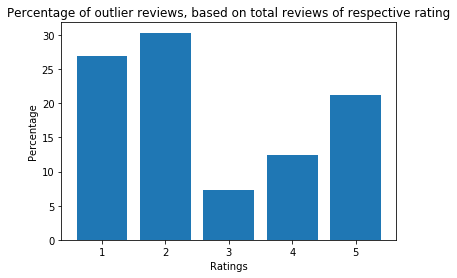

In [11]:
label_outlier_counts = dict(Counter(data[data['num_words']>56]['Label']))
label_total_counts = dict(Counter(data['Label']))


percentage_rating = []
for key in label_outlier_counts.keys():
    percentage_rating.append(label_outlier_counts[key]/label_total_counts[key]*100)


plt.bar(label_counts.keys(),percentage_rating)
plt.xlabel('Ratings')
plt.ylabel("Percentage")
plt.title("Percentage of outlier reviews, based on total reviews of respective rating")

#27% of rating 1 and 30% of rating 2 reviews are the longest
#looks like dissatisfied customer make the longest reviews 
#people who find the course okayish tend to not write too much about it.
#If we remove the outliers, we will remove considerable chunk of rating 1 and 2 reviews
#which are already scarce. Instead, we will just take the first 55 words of each review

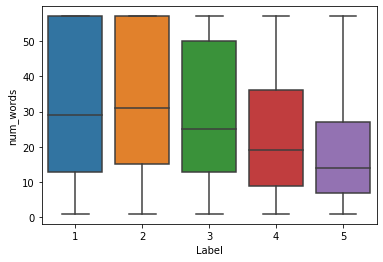

In [12]:
data['cleaned_reviews'] = data['cleaned_reviews'].apply(lambda x: ' '.join(x.split()[:57]))
data['num_words'] = data['cleaned_reviews'].apply(lambda x: len(x.split()))

sns.boxplot(x = 'Label', y = 'num_words',data = data)
#now we have something sane to look at
#There is a thin gap between median line and 75th percentile. This is obvious vecause 25-30% of the top have length 29

In [13]:
#Let's explore the words in our cleaned reviews
def word_level_stats(data, column_name):
    words = []
    for review in data[column_name]:
        words.extend(review.split())

    total_words = len(words)
    print("Total Number of words:", total_words)

    unique_words = len(set(words))
    print("Total Number of unique words aka vocabulary size:", unique_words)

    average_count = int(total_words/unique_words)
    print("Average count:",average_count)
    
    return words

words = word_level_stats(data,'cleaned_reviews')
#On an average each word occurs 111 times! but let's look at the most frequent ones

Total Number of words: 1063676
Total Number of unique words aka vocabulary size: 13720
Average count: 77


In [14]:
def get_frequent_words(word_list,n):
    total_count = len(word_list)
    count_dict = dict(Counter(word_list))
    count_dict = sorted(count_dict.items(), key=lambda x: x[1], reverse = True)
    n_frequent = count_dict[:n]
    
    for word, count in n_frequent:
        print("word:{0}, percentage:{1}".format(word,round(count/total_count*100,2)))
        
        
get_frequent_words(words,10)
#top 10 words occupy more than 25% of total words! Above all, most of these words don't even provide any information.
#these words (the,to,of,...) are called stopwords and we generaly remove them

word:the, percentage:4.63
word:cours, percentage:3.58
word:and, percentage:3.53
word:to, percentage:3.17
word:i, percentage:2.78
word:a, percentage:2.47
word:of, percentage:2.02
word:it, percentage:1.78
word:thi, percentage:1.73
word:is, percentage:1.59


In [15]:
#In text data, it is useful to look at word frequencies. 
#But before that we remove stopwords (useless words like you, your, the,...)

def remove_stopwords(review, stopwords_list):
    return ' '.join([word for word in review.split() if word not in stopwords_list])


In [16]:
data['cleaned_reviews'] = data['cleaned_reviews'].apply(lambda x: remove_stopwords(x, stopwords_list))

In [17]:
data.head()

,Id,Review,Label,cleaned_reviews,num_words,num_stopwords,num_sentences
0,0,good and interesting,5,good interest,3,1,1
1,1,"This class is very helpful to me. Currently, I...",5,class help current still learn class make lot ...,23,12,1
2,2,like!Prof and TAs are helpful and the discussi...,5,like prof ta help discuss among student quit a...,18,6,1
3,3,Easy to follow and includes a lot basic and im...,5,easi follow includ lot basic import techniqu u...,14,5,1
4,4,Really nice teacher!I could got the point eazl...,4,realli nice teacher could got point eazliy v,12,4,1


In [18]:
#Let's repeat this exercise on cleaned reviews
words = word_level_stats(data,'cleaned_reviews')

#Nearly 40-50% of words are removed. Vocabulary size has shrunk a little. Average count per word is now 60

Total Number of words: 562730
Total Number of unique words aka vocabulary size: 13579
Average count: 41


In [19]:
get_frequent_words(words,10)
#most frequent words are now very positive. This is because majority reviews are positives

word:cours, percentage:6.77
word:great, percentage:1.96
word:learn, percentage:1.91
word:good, percentage:1.65
word:thank, percentage:1.11
word:realli, percentage:1.08
word:use, percentage:1.05
word:help, percentage:0.97
word:interest, percentage:0.89
word:lot, percentage:0.89


In [20]:
#Let's look at most frequent words of not so great reviews
words = word_level_stats(data[data['Label']<3],'cleaned_reviews')
get_frequent_words(words,10)
#Strange that good is in the most frequent words? May be it is 'not good'. Let's explore this

Total Number of words: 38058
Total Number of unique words aka vocabulary size: 3820
Average count: 9
word:cours, percentage:4.93
word:video, percentage:0.95
word:lectur, percentage:0.95
word:learn, percentage:0.81
word:much, percentage:0.78
word:content, percentage:0.77
word:materi, percentage:0.76
word:use, percentage:0.76
word:time, percentage:0.73
word:assign, percentage:0.71


In [21]:
#is 'not' in stopwords?
print('not' in stopwords_list)

True


In [22]:
collocations = []
for review in data[data['Label']<3]['Review']:
    collocations.extend(re.findall(r'\w+\s\w+\sgood',review.lower()))

In [23]:
neg_collocations = [coll for coll in collocations if 'no' in coll]

In [24]:
print("Percentage of neg reviews with 'good':",round(len(neg_collocations)/len(collocations)*100,2))
#Only 17% of negative reviews with the word good have 'no/not good'.

Percentage of neg reviews with 'good': 16.35


## Building vectors using TF-IDF

In [25]:
vectorizer = TfidfVectorizer(max_features=5000)
reviews = list(data['cleaned_reviews'])
labels = data['Label']

tfidf_reviews = vectorizer.fit_transform(reviews)

In [26]:
del data

In [27]:
tfidf_array = tfidf_reviews.toarray()
print("Shape of the array:",tfidf_array.shape)

Shape of the array: (50000, 5000)


In [28]:
print("Percentage of zeros:",
      np.count_nonzero(tfidf_array==0)/(tfidf_array.shape[0]*tfidf_array.shape[1])*100)
#only 0.078% of the array elements are non zero. Such a waste of space!

Percentage of zeros: 99.7942996


## PCA: The easy way

In [29]:
NUM_COMPONENTS = 2000
pca = PCA(NUM_COMPONENTS)
reduced = pca.fit_transform(tfidf_array)

In [30]:
variance_explained = np.cumsum(pca.explained_variance_)

Text(0, 0.5, 'Cumulative explained variance')

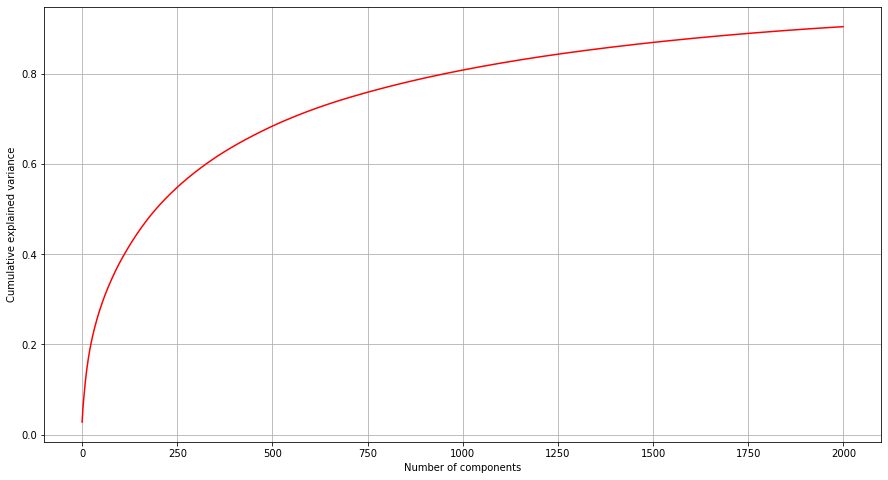

In [31]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(range(NUM_COMPONENTS),variance_explained, color='r')
ax.grid(True)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
#It takes around 300 components to explain 60% of variance. While 300 components post that explain only 10%

In [57]:
NUM_COMPONENTS = 3
pca = PCA(NUM_COMPONENTS)
reduced = pca.fit_transform(tfidf_array)

In [58]:
df = pd.DataFrame(reduced,columns=['A','B','C'])
#labels = [1 if label>4 else 0 for label in labels]
df['Labels'] = labels
# fig,ax = plt.subplots(figsize=(12,7))
# sns.scatterplot(x='A',y='B',data = df, hue='Labels')

Text(0.05, 0.95, 'PCA for n=3 components')

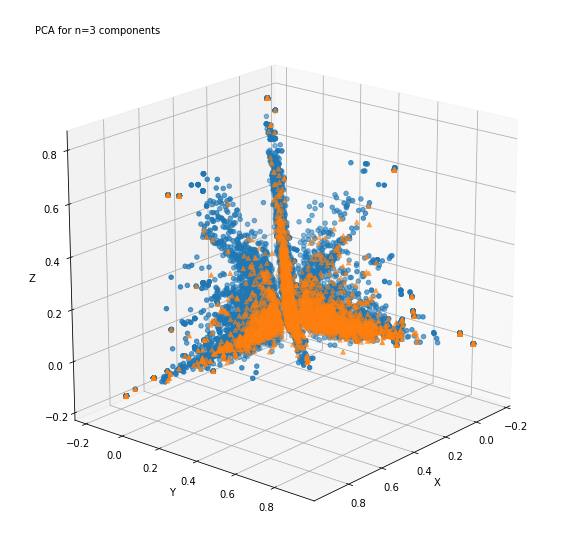

In [74]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 40)
ax.scatter(df[df['Labels']==1]['A'], df[df['Labels']==1]['B'], df[df['Labels']==1]['C'],marker = 'o')
ax.scatter(df[df['Labels']==0]['A'], df[df['Labels']==0]['B'], df[df['Labels']==0]['C'],marker = '^')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.text2D(0.05, 0.95, "PCA for n=3 components", transform=ax.transAxes)

Counter({1: 36445, 0: 13555})